In [1]:
import tensorflow as tf
import numpy as np
from src.dataset import load_dataset

/home/mkosturek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
feature_columns = [tf.feature_column.numeric_column('x',  shape=[32,32,3], dtype=tf.float32)]

In [3]:
import numpy as np
import tensorflow as tf
import logging
from tensorflow.python.training import session_run_hook


class EarlyStoppingHook(session_run_hook.SessionRunHook):
    """Hook that requests stop at a specified step."""

    def __init__(self, monitor='val_loss', min_delta=0, patience=0,
                 mode='auto'):
        """
        """
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                            'fallback to auto mode.', mode, RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def begin(self):
        # Convert names to tensors if given
        graph = tf.get_default_graph()
        self.monitor = graph.as_graph_element(self.monitor)
        if isinstance(self.monitor, tf.Operation):
            self.monitor = self.monitor.outputs[0]

    def before_run(self, run_context):  # pylint: disable=unused-argument
        return session_run_hook.SessionRunArgs(self.monitor)

    def after_run(self, run_context, run_values):
        current = run_values.results

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                run_context.request_stop()

In [4]:
def dense_layer(layer_number, size_prev, size_next, activation_fn, layer_input):
    W = tf.Variable(tf.random_normal([size_prev, size_next]), 
                    name=f'W_{layer_number}')
    b = tf.Variable(tf.random_normal([size_next]),
                    name=f'b_{layer_number}')
    logits = tf.add(tf.matmul(layer_input, W), b)
    activation = activation_fn(logits)
    return activation, logits, W, b
    

def mlp_model(features, labels, mode, params):
    activation = tf.feature_column.input_layer(features, params['feature_columns'])

    predecing_sizes = [params['nb_inputs']] + params['nbs_hidden']
    following_sizes = params['nbs_hidden'] + [params['nb_classes']]
    activation_fns = [tf.nn.sigmoid] * len(params['nbs_hidden']) + [tf.nn.softmax]
    
    regulariser = 0
    for i, (size_prev, size_next, activ_fn) in enumerate(zip(predecing_sizes, 
                                                             following_sizes, 
                                                             activation_fns)):
        activation, logits, W, b = dense_layer(i, size_prev, size_next, 
                                               activ_fn, activation)
        #regulariser += tf.nn.l2_loss(W) + tf.nn.l2_loss(b)
        
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {'class_ids': predicted_classes[:, tf.newaxis],
                       'probabilities': activation,
                       'logits': logits}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        #loss = tf.add(loss, 0.01 * regulariser, name='val_loss')
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    assert mode == tf.estimator.ModeKeys.TRAIN
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    #loss = tf.add(loss, 0.01 * regulariser, name='loss')
    
    optimiser = tf.train.AdamOptimizer(learning_rate=1e-3)
    train_op = optimiser.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [5]:
classifier = tf.estimator.Estimator(model_fn=mlp_model,
                                   params={'feature_columns': feature_columns,
                                           'nb_inputs': 32 * 32 * 3,
                                           'nb_classes': 10,
                                           'nbs_hidden': [128, 128]},)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgl_gsx3f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a96c3e2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [37]:
early_stopping_hook = EarlyStoppingHook(monitor='loss', mode='min', patience=2)
classifier.train(input_fn=lambda: load_dataset('data/train.tfrecords', epochs=20))#,
                 #hooks=[early_stopping_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmps96vusd7/model.ckpt.
INFO:tensorflow:loss = 6.9432535, step = 0
INFO:tensorflow:global_step/sec: 762.077
INFO:tensorflow:loss = 2.3964572, step = 100 (0.132 sec)
INFO:tensorflow:global_step/sec: 989.654
INFO:tensorflow:loss = 2.4091616, step = 200 (0.101 sec)
INFO:tensorflow:global_step/sec: 923.38
INFO:tensorflow:loss = 2.137053, step = 300 (0.110 sec)
INFO:tensorflow:global_step/sec: 997.286
INFO:tensorflow:loss = 2.220605, step = 400 (0.099 sec)
INFO:tensorflow:global_step/sec: 950.714
INFO:tensorflow:loss = 2.3752031, step = 500 (0.105 sec)
INFO:tensorflow:global_step/sec: 981.117
INFO:tensorflow:loss = 2.3030875, step = 600 (0.102 sec)
INFO:tensorflow:global_step/sec: 969.923
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 963.78
INFO:tensorflow:loss = 1.6946757, step = 8100 (0.103 sec)
INFO:tensorflow:global_step/sec: 938.884
INFO:tensorflow:loss = 1.8919418, step = 8200 (0.107 sec)
INFO:tensorflow:global_step/sec: 956.267
INFO:tensorflow:loss = 1.5227773, step = 8300 (0.104 sec)
INFO:tensorflow:global_step/sec: 1000.19
INFO:tensorflow:loss = 1.793333, step = 8400 (0.100 sec)
INFO:tensorflow:global_step/sec: 933.755
INFO:tensorflow:loss = 1.9242792, step = 8500 (0.107 sec)
INFO:tensorflow:global_step/sec: 951.294
INFO:tensorflow:loss = 1.5579913, step = 8600 (0.105 sec)
INFO:tensorflow:global_step/sec: 961.093
INFO:tensorflow:loss = 1.7185421, step = 8700 (0.104 sec)
INFO:tensorflow:global_step/sec: 972.527
INFO:tensorflow:loss = 1.6967613, step = 8800 (0.103 sec)
INFO:tensorflow:global_step/sec: 998.456
INFO:tensorflow:loss = 1.6538818, step = 8900 (0.100 sec)
INFO:tensorflow:global_step/sec: 1038.06
INFO:tensorflow:loss = 1.7428995, step = 9000 (0.096 sec)
INFO:tensorf

INFO:tensorflow:loss = 1.5779122, step = 16300 (0.101 sec)
INFO:tensorflow:global_step/sec: 989.781
INFO:tensorflow:loss = 1.6403979, step = 16400 (0.101 sec)
INFO:tensorflow:global_step/sec: 970.773
INFO:tensorflow:loss = 1.3964156, step = 16500 (0.103 sec)
INFO:tensorflow:global_step/sec: 961.908
INFO:tensorflow:loss = 1.8469412, step = 16600 (0.104 sec)
INFO:tensorflow:global_step/sec: 993.052
INFO:tensorflow:loss = 1.872301, step = 16700 (0.101 sec)
INFO:tensorflow:global_step/sec: 993.287
INFO:tensorflow:loss = 1.9083524, step = 16800 (0.101 sec)
INFO:tensorflow:global_step/sec: 938.317
INFO:tensorflow:loss = 1.5474933, step = 16900 (0.106 sec)
INFO:tensorflow:global_step/sec: 929.896
INFO:tensorflow:loss = 1.4074943, step = 17000 (0.107 sec)
INFO:tensorflow:global_step/sec: 941.577
INFO:tensorflow:loss = 1.7552756, step = 17100 (0.106 sec)
INFO:tensorflow:global_step/sec: 344.591
INFO:tensorflow:loss = 1.4106648, step = 17200 (0.290 sec)
INFO:tensorflow:global_step/sec: 994.691
I

INFO:tensorflow:global_step/sec: 983.673
INFO:tensorflow:loss = 1.5446107, step = 24600 (0.102 sec)
INFO:tensorflow:global_step/sec: 997.983
INFO:tensorflow:loss = 1.6976094, step = 24700 (0.100 sec)
INFO:tensorflow:global_step/sec: 982.236
INFO:tensorflow:loss = 1.7992048, step = 24800 (0.102 sec)
INFO:tensorflow:global_step/sec: 973.898
INFO:tensorflow:loss = 1.7120373, step = 24900 (0.103 sec)
INFO:tensorflow:global_step/sec: 346.187
INFO:tensorflow:loss = 1.6658506, step = 25000 (0.289 sec)
INFO:tensorflow:global_step/sec: 975.717
INFO:tensorflow:loss = 1.3320663, step = 25100 (0.103 sec)
INFO:tensorflow:global_step/sec: 908.411
INFO:tensorflow:loss = 1.6843696, step = 25200 (0.110 sec)
INFO:tensorflow:global_step/sec: 942.809
INFO:tensorflow:loss = 1.5686691, step = 25300 (0.106 sec)
INFO:tensorflow:global_step/sec: 972.455
INFO:tensorflow:loss = 1.7309351, step = 25400 (0.103 sec)
INFO:tensorflow:global_step/sec: 963.638
INFO:tensorflow:loss = 1.6181216, step = 25500 (0.104 sec)


In [38]:
classifier.evaluate(lambda : load_dataset('data/test.tfrecords', epochs=1))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-09-12:29:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmps96vusd7/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-09-12:29:33
INFO:tensorflow:Saving dict for global step 31250: accuracy = 0.4099, global_step = 31250, loss = 1.6713082
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 31250: /tmp/tmps96vusd7/model.ckpt-31250


{'accuracy': 0.4099, 'loss': 1.6713082, 'global_step': 31250}

In [39]:
pred = classifier.predict(lambda: load_dataset('data/test.tfrecords', epochs=1, batch_size=1))

In [40]:
for p in pred:
    g =p

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmps96vusd7/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [41]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

In [42]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)

In [43]:
raw_predictions = classifier.predict(input_fn=test_input_fn)
predictions = np.asarray([p['class_ids'][0] for p in raw_predictions])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmps96vusd7/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [44]:
confusion_matrix = tf.confusion_matrix(y_test, predictions)
with tf.Session() as sess:
    cm = tf.Tensor.eval(confusion_matrix,feed_dict=None, 
                        session=sess)
    print('\nConfusion Matrix:\n', cm)


Confusion Matrix:
 [[426  47 100  12  40  11  45  38 229  52]
 [ 33 536  23  30  25  24  37  26 103 163]
 [110  39 215  70 197  71 178  58  43  19]
 [ 29  38  86 182  82 221 203  53  43  63]
 [ 58  20 134  37 365  56 202  77  32  19]
 [ 14  27  99 106  86 378 174  50  47  19]
 [  5  27  68  54 139  67 585  15  17  23]
 [ 41  33  67  53 110  84 123 379  37  73]
 [101  76  28  18  22  42  11  13 617  72]
 [ 31 235  16  26  16  19  59  39 143 416]]


In [46]:
cm.trace()/cm.sum()

0.4099

In [47]:
y_test==8

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

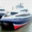

In [48]:
from PIL import Image
im = (x_test[1].reshape((32,32,3))*255).astype(np.uint8)
Image.fromarray(im)

In [32]:
(x_test[1].reshape((32,32,3))*255).astype(int).dtype

dtype('int64')

In [49]:
from matplotlib import pyplot

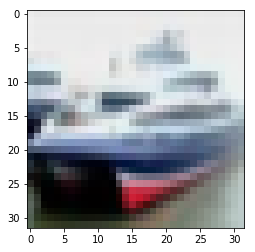

In [50]:
pyplot.imshow(im)